In [123]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import roc_curve
import lightgbm as lgb
import time
import gc
import seaborn as sns
from sklearn import metrics
import warnings
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
import random
from sklearn.neighbors import NearestNeighbors
from sklearn import tree

In [124]:
train = pd.read_csv('./BS_data.csv',sep='\t')

In [125]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 35 columns):
性别             479 non-null int64
年龄             479 non-null int64
*天门冬氨酸氨基转换酶    479 non-null float64
*丙氨酸氨基转换酶      479 non-null float64
*碱性磷酸酶         479 non-null float64
*r-谷氨酰基转换酶     479 non-null float64
*总蛋白           479 non-null float64
白蛋白            479 non-null float64
*球蛋白           479 non-null float64
白球比例           479 non-null float64
甘油三酯           479 non-null float64
总胆固醇           479 non-null float64
高密度脂蛋白胆固醇      479 non-null float64
低密度脂蛋白胆固醇      479 non-null float64
尿素             479 non-null float64
肌酐             479 non-null float64
尿酸             479 non-null float64
白细胞计数          479 non-null float64
红细胞计数          479 non-null float64
血红蛋白           479 non-null float64
红细胞压积          479 non-null float64
红细胞平均体积        479 non-null float64
红细胞平均血红蛋白量     479 non-null float64
红细胞平均血红蛋白浓度    479 non-null float64
红细胞体积分布宽度      479 non-null float64

In [126]:
def Sex2Num(x):
    if x == '男':
        x = 1
    else:
        x=0
    return x

train['性别'] = train['性别'].apply(Sex2Num)
train.head()

,性别,年龄,*天门冬氨酸氨基转换酶,*丙氨酸氨基转换酶,*碱性磷酸酶,*r-谷氨酰基转换酶,*总蛋白,白蛋白,*球蛋白,白球比例,...,血小板计数,血小板平均体积,血小板体积分布宽度,血小板比积,中性粒细胞%,淋巴细胞%,单核细胞%,嗜酸细胞%,嗜碱细胞%,血糖
0,0,48,24.73,39.40,137.68,60.00,78.05,50.57,27.48,1.84,...,234.0,10.7,13.8,0.25,51.5,37.4,8.6,1.3,1.2,1
1,0,38,15.12,14.53,87.19,31.54,80.55,49.15,31.40,1.57,...,191.0,12.2,16.6,0.23,64.0,26.5,7.9,1.1,0.5,2
2,0,59,30.71,43.14,115.32,86.04,86.27,46.67,39.60,1.18,...,295.0,9.8,10.5,0.29,60.8,24.5,9.3,4.6,0.8,1
3,0,54,23.56,26.69,109.51,18.72,76.16,44.59,31.57,1.41,...,229.0,10.6,12.5,0.24,55.4,33.0,9.0,1.9,0.7,1
4,0,58,18.50,27.27,108.39,56.01,74.93,42.62,32.31,1.32,...,217.0,9.7,10.3,0.21,57.9,30.8,7.4,3.0,0.9,1


In [127]:
from pylab import mpl

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False

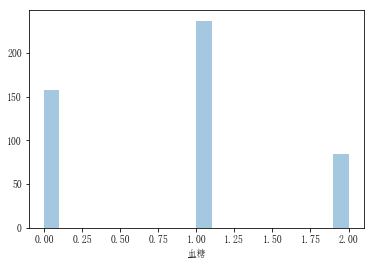

In [128]:
sns.distplot(train['血糖'], bins=20, kde=False)
#可视化轻度、中度、重度高血糖的的样本数

In [129]:
y = train['血糖']
X = train.drop(['血糖'], axis=1)

In [130]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=15)
def train_model(X=X,  y=y, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, averaging='usual', make_oof=False):
    result_dict = {}
    if make_oof:
        oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        gc.collect()
        print('Fold', fold_n + 1, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=5000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 500)

            del train_data, valid_data
            
            y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration).argmax(1)
            del X_valid
            gc.collect()
            y_pred = model.predict(X_test, num_iteration=model.best_iteration).argmax(1)

        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    

    
    if model_type == 'lgb':
        
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            best_feature =  best_features.groupby('feature').mean()
            best_feature['feature'] = best_feature.index
            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_feature.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            
    result_dict['prediction'] = prediction
    if make_oof:
        result_dict['oof'] = oof
    
    return result_dict

In [131]:
params = {'num_leaves': 8,
         #'min_data_in_leaf': 60,
         'objective': 'multiclass',
         'max_depth': -1,
         'learning_rate': 0.003,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 5,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
        #  "lambda_l1": 0.1,
         # "lambda_l2": 0.1,
         "random_state": 42,          
         "verbosity": -1,
         "num_class": 3}

Fold 1 started at Wed May 22 15:10:35 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.745463	valid_1's multi_logloss: 1.00954
Early stopping, best iteration is:
[465]	training's multi_logloss: 0.760315	valid_1's multi_logloss: 1.00741
Fold 2 started at Wed May 22 15:10:37 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.744488	valid_1's multi_logloss: 1.0247
Early stopping, best iteration is:
[77]	training's multi_logloss: 0.965021	valid_1's multi_logloss: 1.01749
Fold 3 started at Wed May 22 15:10:37 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0.733607	valid_1's multi_logloss: 1.04322
Early stopping, best iteration is:
[1]	training's multi_logloss: 1.0177	valid_1's multi_logloss: 1.02258
Fold 4 started at Wed May 22 15:10:39 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's multi_logloss: 0

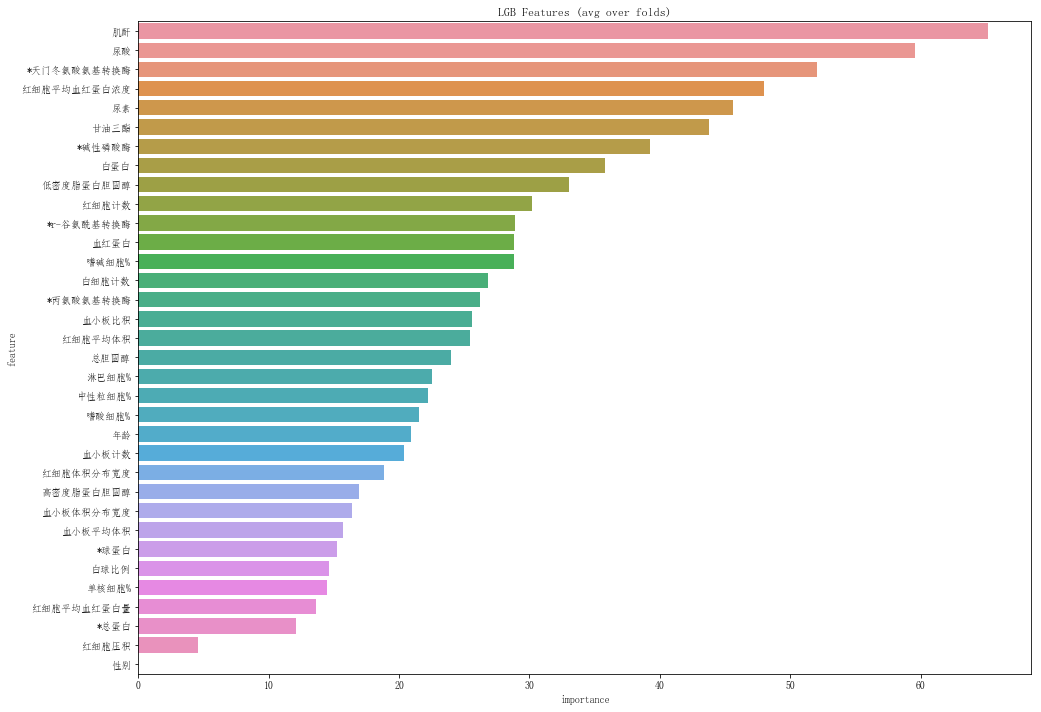

In [132]:
result_dict_lgb = train_model(X=X,  y=y, params=params, model_type='lgb', plot_feature_importance=True, make_oof=True)

In [133]:
col = ['肌酐','尿酸','尿素','甘油三酯','*碱性磷酸酶','红细胞平均血红蛋白浓度','*天门冬氨酸氨基转换酶','白蛋白']
X_data = X.loc[:, col]

In [134]:
X_train,X_test, y_train, y_test =train_test_split(X_data,y,test_size=0.3, random_state=0)
clf = tree.DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=4,min_samples_split=15)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=15,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [135]:
import pydotplus
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image 

dot_data = StringIO()
export_graphviz(
    clf,
    out_file=dot_data,
    class_names=['轻度高血糖','中度高血糖','重度高血糖'],
    feature_names=col,
    filled=True,rounded=True,special_characters=True
)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue().replace('helvetica','"Microsoft YaHei"'))
graph.write_png('Tree.png')

True

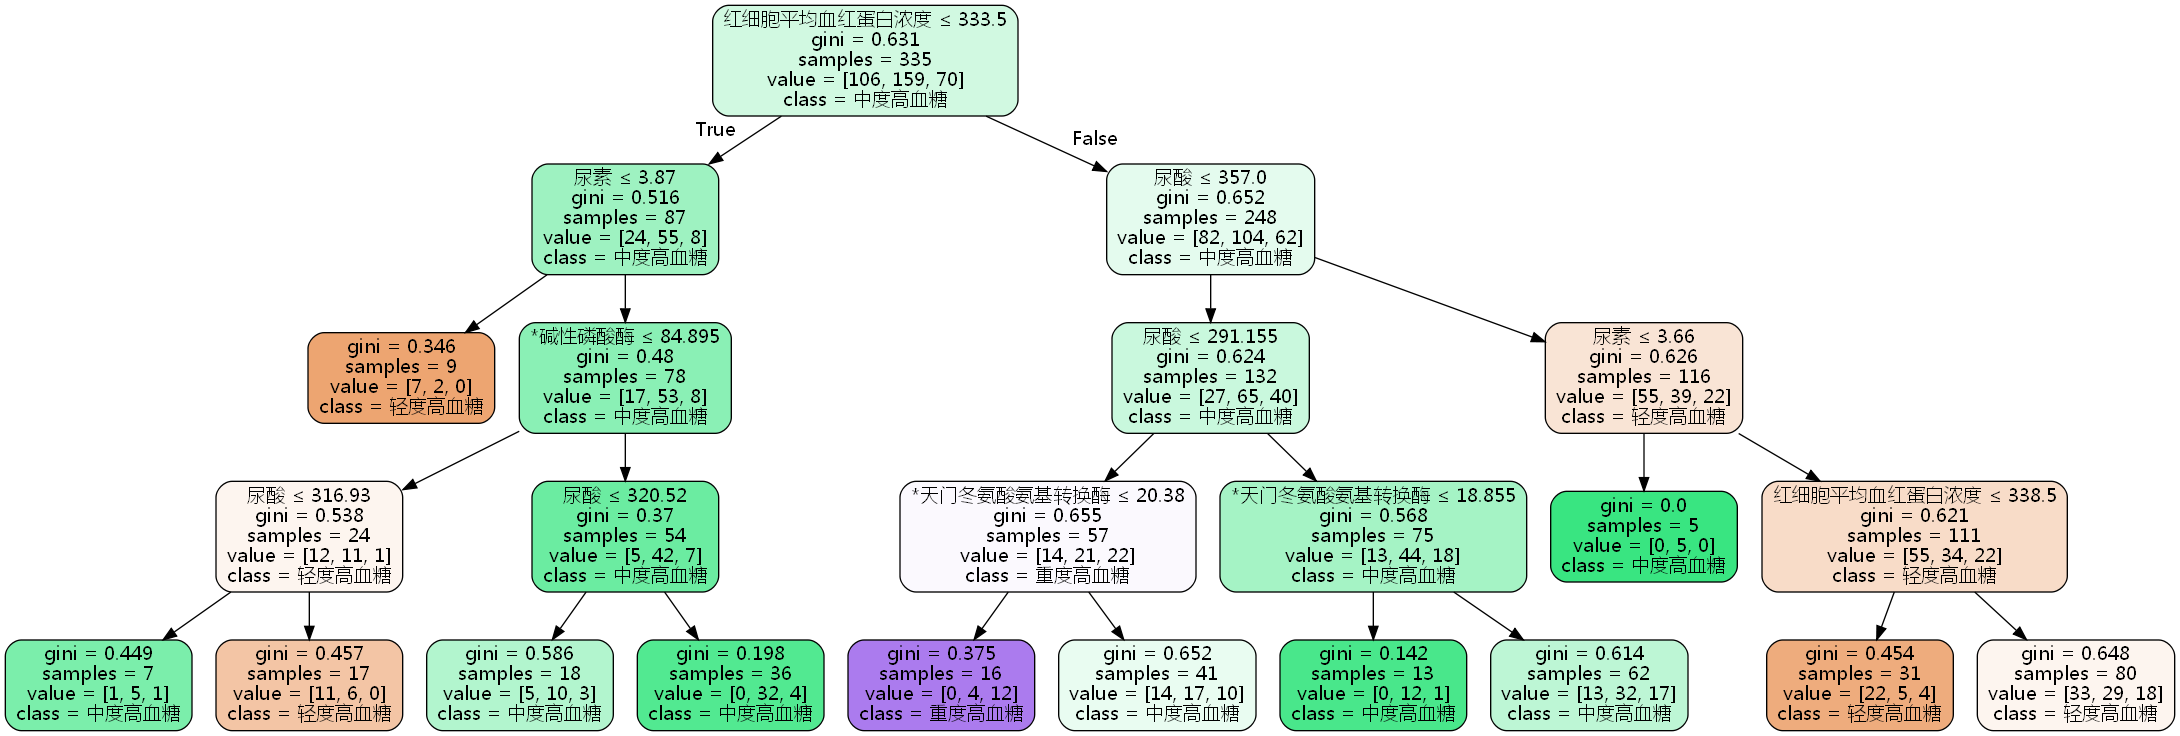

In [136]:
Image(graph.create_png()) 